In [1]:
# Importações
import os
import warnings
from pathlib import Path
import shutil
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from IPython.display import Audio

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, Flatten,
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau
)
from tensorflow.keras.utils import to_categorical



In [2]:
# Configurações iniciais
warnings.filterwarnings("ignore")
tf.random.set_seed(42)
np.random.seed(42)



In [3]:
# Definindo o diretório de dados
data_dir = "MIMII_dataset"

# Verificando se o diretório existe, caso contrário, cria-o
if not os.path.exists(data_dir):
    os.makedirs(data_dir, exist_ok=True)
    print("Diretório criado:", data_dir)
else:
    print("Diretório já existe:", data_dir)

# Dicionário dos datasets
data_dirs = {
    '6_dB_fan': os.path.join(data_dir, '6_dB_fan'),
    '0_dB_fan': os.path.join(data_dir, '0_dB_fan'),
    '-6_dB_fan': os.path.join(data_dir, '-6_dB_fan'),
}

# Criando os diretórios de dados, se não existirem
for dataset_name, dataset_dir in data_dirs.items():
    if not os.path.exists(dataset_dir):
        os.makedirs(dataset_dir, exist_ok=True)
        print("Diretório criado:", dataset_dir)
    else:
        print("Diretório já existe:", dataset_dir)

# Baixando e descompactando os datasets
for dataset_name, dataset_dir in data_dirs.items():
    if dataset_name == '6_dB_fan':
        url = 'https://zenodo.org/record/3384388/files/6_dB_fan.zip?download=1'
        zip_file = '/tmp/6_dB_fan.zip'
    elif dataset_name == '0_dB_fan':
        url = 'https://zenodo.org/record/3384388/files/0_dB_fan.zip?download=1'
        zip_file = '/tmp/0_dB_fan.zip'
    elif dataset_name == '-6_dB_fan':
        url = 'https://zenodo.org/record/3384388/files/-6_dB_fan.zip?download=1'
        zip_file = '/tmp/-6_dB_fan.zip'
    else:
        continue
    # Download
    if not os.path.exists(zip_file):
        print(f"Baixando {dataset_name}...")
        !wget -O {zip_file} {url}
    else:
        print(f"Arquivo {zip_file} já existe. Pulando download.")
    # Unzip
    print(f"Descompactando {dataset_name}...")
    !unzip -q {zip_file} -d {dataset_dir}

# Diretório para dados não vistos pelo modelo
unseen_data_dir = os.path.join(data_dir, 'unseen_data')

if not os.path.exists(unseen_data_dir):
    os.makedirs(unseen_data_dir, exist_ok=True)
    print("Diretório criado:", unseen_data_dir)
else:
    print("Diretório já existe:", unseen_data_dir)

# Selecionando 10 arquivos de cada id de cada tipo para 'unseen_data'
for dataset_name, dataset_dir in data_dirs.items():
    machine_type = 'fan'
    ids = os.listdir(os.path.join(dataset_dir, machine_type))
    for machine_id in ids:
        # Caminho para os arquivos de áudio
        for class_label in ['normal', 'abnormal']:
            source_dir = os.path.join(dataset_dir, machine_type, machine_id, class_label)
            if os.path.exists(source_dir):
                # Listando arquivos .wav
                audio_files = [f for f in os.listdir(source_dir) if f.endswith('.wav')]
                # Selecionando 10 arquivos aleatórios
                selected_files = random.sample(audio_files, min(10, len(audio_files)))
                for file_name in selected_files:
                    src_file = os.path.join(source_dir, file_name)
                    dest_dir = os.path.join(unseen_data_dir, dataset_name, machine_type, machine_id, class_label)
                    os.makedirs(dest_dir, exist_ok=True)
                    dest_file = os.path.join(dest_dir, file_name)
                    print(f"Movendo {src_file} para {dest_file}")
                    shutil.move(src_file, dest_file)
            else:
                print(f"Diretório {source_dir} não existe.")



Diretório criado: MIMII_dataset
Diretório criado: MIMII_dataset/6_dB_fan
Diretório criado: MIMII_dataset/0_dB_fan
Diretório criado: MIMII_dataset/-6_dB_fan
Baixando 6_dB_fan...
--2024-12-04 17:58:05--  https://zenodo.org/record/3384388/files/6_dB_fan.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/3384388/files/6_dB_fan.zip [following]
--2024-12-04 17:58:06--  https://zenodo.org/records/3384388/files/6_dB_fan.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 10158673161 (9.5G) [application/octet-stream]
Saving to: ‘/tmp/6_dB_fan.zip’

/tmp/6_dB_fan.zip   100%[===================>]   9.46G  23.9MB/s    in 6m 47s  

2024-12-04 18:04:53 (23.8 MB/s) - ‘/tmp/6_dB_fan.zip’ saved [10158673161/10158673161]

Descompactando 6_dB_fan...
Ba

In [5]:
class AudioAnomalyDetector:
    def __init__(self, data_dir='MIMII_dataset', n_mfcc=64, model_path='best_model_complete.keras'):
        """
        Inicializa o detector de anomalias em áudio.

        Args:
            data_dir (str): Diretório dos dados
            n_mfcc (int): Número de coeficientes MFCCs
            model_path (str): Caminho para o modelo salvo
        """
        self.data_dir = data_dir
        self.n_mfcc = n_mfcc
        self.model = None
        self.model_path = model_path
        self.label_encoder = LabelEncoder()

    def load_dataset(self):
        """Carrega e organiza o conjunto de dados."""
        audio_files = list(Path(self.data_dir).rglob('*.wav'))
        df = pd.DataFrame({'file_path': [str(file) for file in audio_files]})

        df['machine_type'] = df['file_path'].apply(lambda x: x.split('/')[-4])
        df['machine_id'] = df['file_path'].apply(lambda x: x.split('/')[-3])
        df['class'] = df['file_path'].apply(lambda x: x.split('/')[-2])
        df['file_name'] = df['file_path'].apply(lambda x: x.split('/')[-1])

        # Invertendo os rótulos: 'normal' = 0 e 'abnormal' = 1
        df['class'] = df['class'].map({'normal': 0, 'abnormal': 1})

        self._plot_class_distribution(df)
        display(df.head())
        return df

    def _plot_class_distribution(self, df):
        """Plota a distribuição das classes."""
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x='class')
        plt.title('Distribuição das Classes de Áudio')
        plt.xlabel('Classe (0 = Normal, 1 = Anomalous)')
        plt.ylabel('Contagem')
        plt.tight_layout()
        plt.show()

    def extract_features(self, file_path):
        """Extrai características MFCC do arquivo de áudio."""
        audio, sample_rate = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=self.n_mfcc)
        return np.mean(mfccs.T, axis=0)

    def prepare_data(self, df):
        """Prepara dados para treinamento."""
        features = []
        labels = []

        for _, row in df.iterrows():
            feature = self.extract_features(row['file_path'])
            features.append(feature)
            labels.append(row['class'])

        X = np.array(features)
        y = np.array(labels)

        return X, y

    def build_model(self, input_shape):
        """Constrói modelo de rede neural para classificação."""
        model = Sequential([
            Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
            BatchNormalization(),
            MaxPooling1D(pool_size=2),
            Dropout(0.3),

            Conv1D(128, kernel_size=3, activation='relu'),
            BatchNormalization(),
            MaxPooling1D(pool_size=2),
            Dropout(0.3),

            Flatten(),
            Dense(64, activation='relu'),
            BatchNormalization(),
            Dropout(0.4),

            Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
        )

        return model

    def train(self, X, y, test_size=0.2, val_size=0.5):
        """Treina o modelo com validação cruzada estratificada."""
        X = X[..., np.newaxis]  # Adiciona dimensão para Conv1D

        # Divisão estratificada dos dados
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=42
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=val_size, stratify=y_temp, random_state=42
        )

        # Callbacks
        callbacks = [
            ModelCheckpoint('best_model_weights.keras', monitor='val_auc', save_best_only=True, mode='max'),
            EarlyStopping(monitor='val_auc', patience=10, mode='max'),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
        ]

        # Treinamento
        self.model = self.build_model(X_train.shape[1:])
        history = self.model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=32,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

        # Carrega os melhores pesos
        self.model.load_weights('best_model_weights.keras')

        # Salva o modelo completo
        self.model.save(self.model_path)

        # Avaliação
        self._evaluate_model(X_test, y_test)

        return history

    def _evaluate_model(self, X_test, y_test):
        """Avalia o modelo e gera métricas detalhadas."""
        y_pred = self.model.predict(X_test).flatten()
        y_pred_classes = (y_pred > 0.5).astype(int)

        # Métricas detalhadas
        accuracy = accuracy_score(y_test, y_pred_classes)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, y_pred_classes, average='binary'
        )
        auc = roc_auc_score(y_test, y_pred)

        print(f'\nAcurácia: {accuracy * 100:.2f}%')
        print(f'Precisão: {precision * 100:.2f}%')
        print(f'Recall: {recall * 100:.2f}%')
        print(f'F1-Score: {f1 * 100:.2f}%')
        print(f'AUC: {auc:.4f}\n')
        print('\n')
        print(classification_report(y_test, y_pred_classes))

        # Matriz de confusão
        cm = confusion_matrix(y_test, y_pred_classes)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Matriz de Confusão')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.tight_layout()
        plt.show()

        # Curva ROC
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('Curva ROC')
        plt.xlabel('Taxa de Falsos Positivos')
        plt.ylabel('Taxa de Verdadeiros Positivos')
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.show()

    def predict_audio(self, file_path):
        """Prediz a classe de um arquivo de áudio individual."""
        # Carrega o modelo salvo se ainda não estiver carregado
        if self.model is None:
            self.model = tf.keras.models.load_model(self.model_path)

        feature = self.extract_features(file_path)
        feature = feature.reshape(1, feature.shape[0], 1)

        prediction = self.model.predict(feature)
        predicted_class = "normal" if prediction[0][0] < 0.5 else "anomalia"

        audio, sr = librosa.load(file_path, sr=None)
        display(Audio(data=audio, rate=sr))

        return predicted_class


Processando dataset: 6_dB_fan


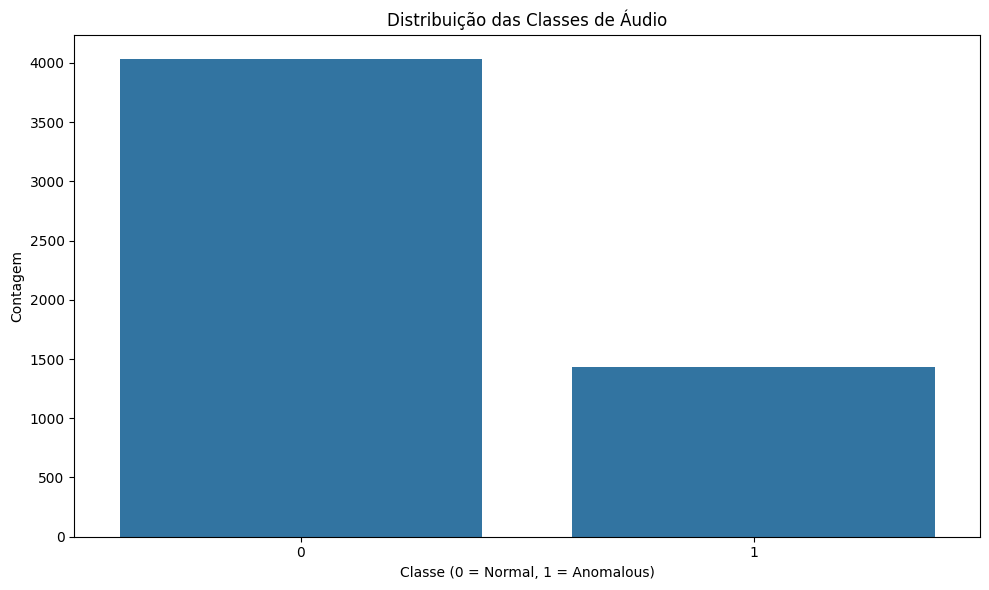

,file_path,machine_type,machine_id,class,file_name
0,MIMII_dataset/6_dB_fan/fan/id_00/normal/000002...,fan,id_00,0,00000207.wav
1,MIMII_dataset/6_dB_fan/fan/id_00/normal/000001...,fan,id_00,0,00000129.wav
2,MIMII_dataset/6_dB_fan/fan/id_00/normal/000004...,fan,id_00,0,00000460.wav
3,MIMII_dataset/6_dB_fan/fan/id_00/normal/000009...,fan,id_00,0,00000918.wav
4,MIMII_dataset/6_dB_fan/fan/id_00/normal/000007...,fan,id_00,0,00000707.wav


Epoch 1/50
137/137 [==============================] - 4s 16ms/step - loss: 0.3626 - accuracy: 0.8416 - auc: 0.9391 - val_loss: 0.1423 - val_accuracy: 0.9744 - val_auc: 0.9989 - lr: 0.0010
Epoch 2/50
137/137 [==============================] - 2s 12ms/step - loss: 0.1052 - accuracy: 0.9669 - auc: 0.9943 - val_loss: 0.0241 - val_accuracy: 1.0000 - val_auc: 1.0000 - lr: 0.0010
Epoch 3/50
137/137 [==============================] - 2s 12ms/step - loss: 0.0583 - accuracy: 0.9824 - auc: 0.9976 - val_loss: 0.0078 - val_accuracy: 1.0000 - val_auc: 1.0000 - lr: 0.0010
Epoch 4/50
137/137 [==============================] - 2s 12ms/step - loss: 0.0451 - accuracy: 0.9877 - auc: 0.9986 - val_loss: 0.0081 - val_accuracy: 0.9982 - val_auc: 1.0000 - lr: 0.0010
Epoch 5/50
137/137 [==============================] - 2s 12ms/step - loss: 0.0347 - accuracy: 0.9893 - auc: 0.9992 - val_loss: 0.0034 - val_accuracy: 1.0000 - val_auc: 1.0000 - lr: 0.0010
Epoch 6/50
137/137 [==============================] - 2s 12m

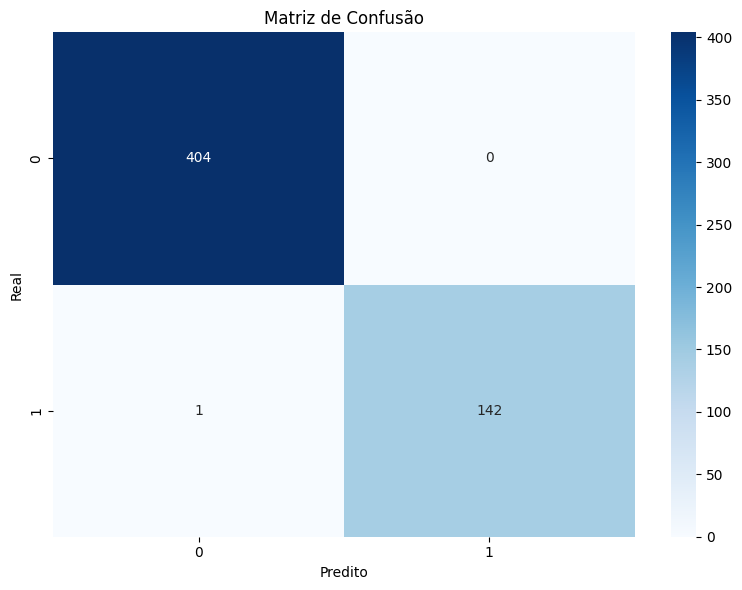

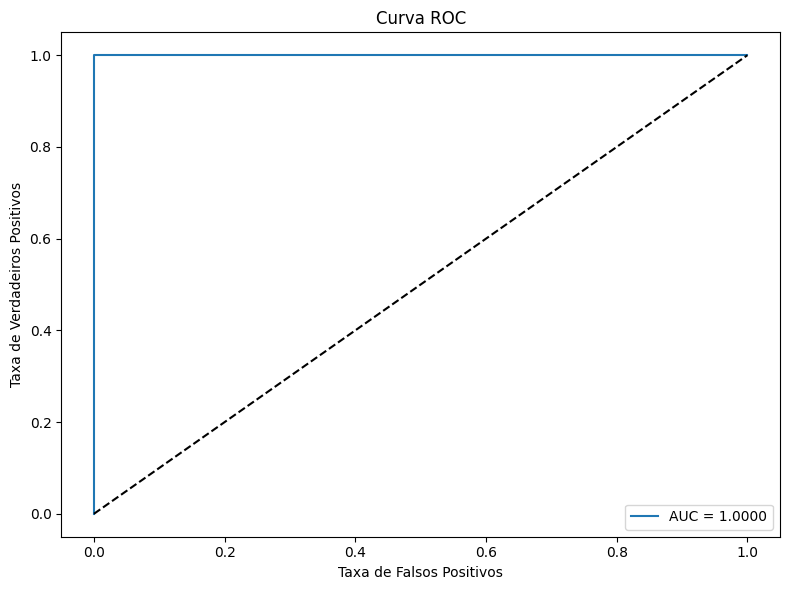


Processando dataset: 0_dB_fan


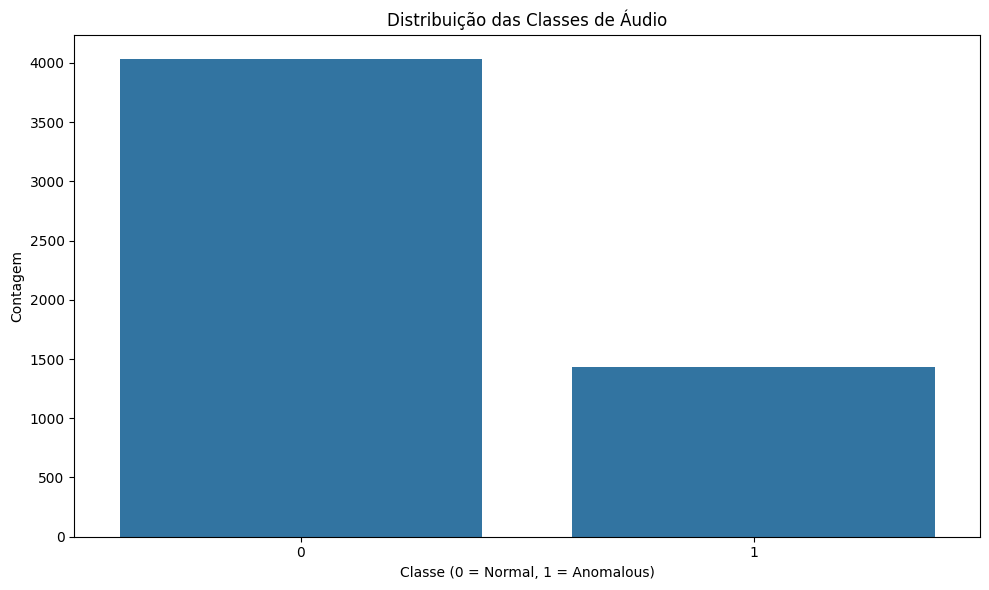

,file_path,machine_type,machine_id,class,file_name
0,MIMII_dataset/0_dB_fan/fan/id_00/normal/000002...,fan,id_00,0,00000207.wav
1,MIMII_dataset/0_dB_fan/fan/id_00/normal/000001...,fan,id_00,0,00000129.wav
2,MIMII_dataset/0_dB_fan/fan/id_00/normal/000004...,fan,id_00,0,00000460.wav
3,MIMII_dataset/0_dB_fan/fan/id_00/normal/000009...,fan,id_00,0,00000918.wav
4,MIMII_dataset/0_dB_fan/fan/id_00/normal/000007...,fan,id_00,0,00000707.wav


Epoch 1/50
137/137 [==============================] - 4s 16ms/step - loss: 0.5476 - accuracy: 0.7427 - auc: 0.8236 - val_loss: 0.4290 - val_accuracy: 0.7989 - val_auc: 0.9117 - lr: 0.0010
Epoch 2/50
137/137 [==============================] - 2s 13ms/step - loss: 0.2622 - accuracy: 0.8951 - auc: 0.9483 - val_loss: 0.1490 - val_accuracy: 0.9488 - val_auc: 0.9876 - lr: 0.0010
Epoch 3/50
137/137 [==============================] - 2s 12ms/step - loss: 0.1864 - accuracy: 0.9289 - auc: 0.9723 - val_loss: 0.0989 - val_accuracy: 0.9726 - val_auc: 0.9935 - lr: 0.0010
Epoch 4/50
137/137 [==============================] - 2s 12ms/step - loss: 0.1543 - accuracy: 0.9429 - auc: 0.9805 - val_loss: 0.0862 - val_accuracy: 0.9707 - val_auc: 0.9949 - lr: 0.0010
Epoch 5/50
137/137 [==============================] - 2s 12ms/step - loss: 0.1240 - accuracy: 0.9541 - auc: 0.9861 - val_loss: 0.0685 - val_accuracy: 0.9817 - val_auc: 0.9964 - lr: 0.0010
Epoch 6/50
137/137 [==============================] - 2s 12m

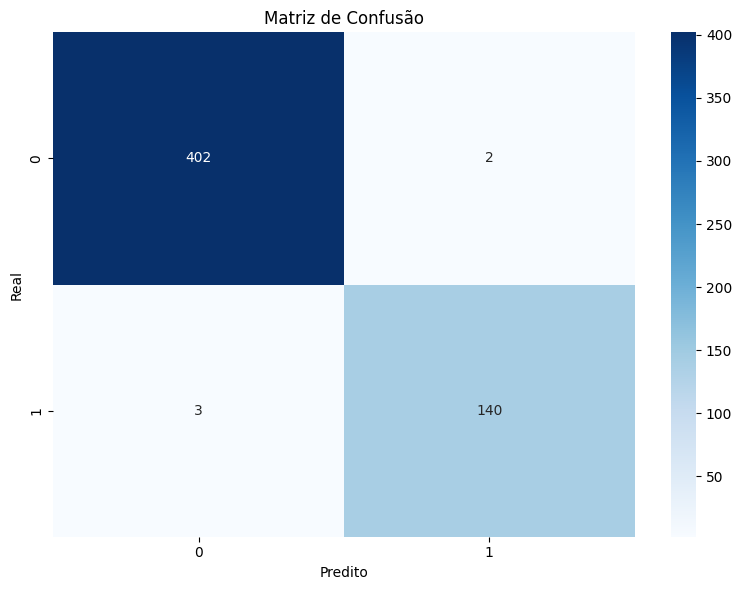

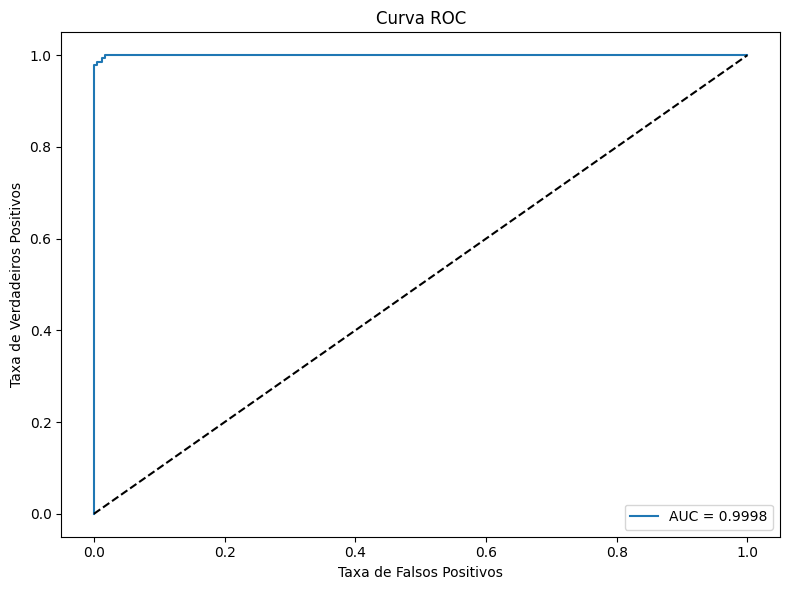


Processando dataset: -6_dB_fan


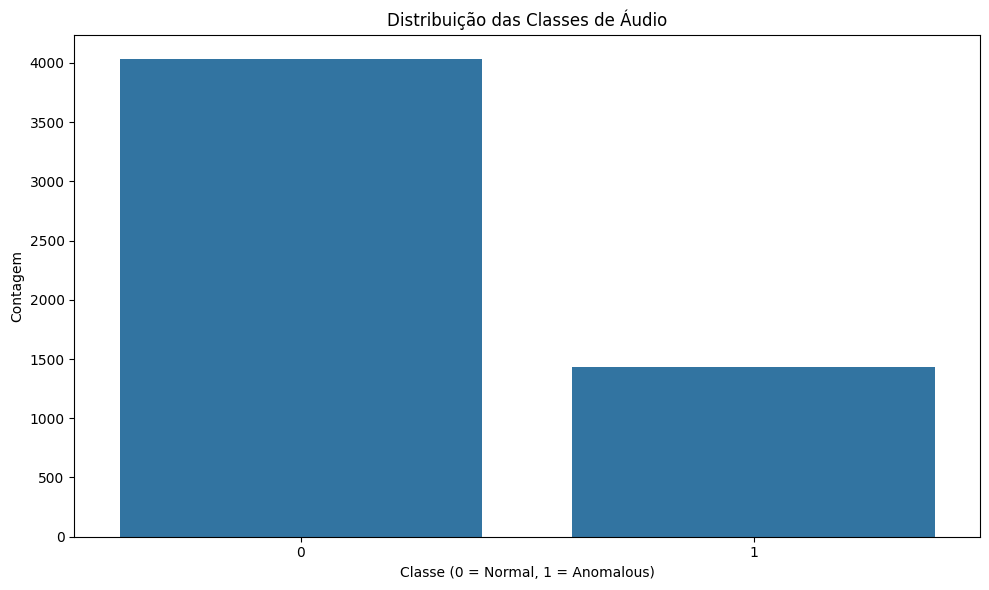

,file_path,machine_type,machine_id,class,file_name
0,MIMII_dataset/-6_dB_fan/fan/id_00/normal/00000...,fan,id_00,0,00000207.wav
1,MIMII_dataset/-6_dB_fan/fan/id_00/normal/00000...,fan,id_00,0,00000129.wav
2,MIMII_dataset/-6_dB_fan/fan/id_00/normal/00000...,fan,id_00,0,00000460.wav
3,MIMII_dataset/-6_dB_fan/fan/id_00/normal/00000...,fan,id_00,0,00000918.wav
4,MIMII_dataset/-6_dB_fan/fan/id_00/normal/00000...,fan,id_00,0,00000707.wav


Epoch 1/50
137/137 [==============================] - 4s 16ms/step - loss: 0.6940 - accuracy: 0.6538 - auc: 0.6640 - val_loss: 0.5214 - val_accuracy: 0.8172 - val_auc: 0.8410 - lr: 0.0010
Epoch 2/50
137/137 [==============================] - 2s 13ms/step - loss: 0.5138 - accuracy: 0.7532 - auc: 0.7665 - val_loss: 0.3910 - val_accuracy: 0.8501 - val_auc: 0.8812 - lr: 0.0010
Epoch 3/50
137/137 [==============================] - 2s 13ms/step - loss: 0.4388 - accuracy: 0.7943 - auc: 0.8267 - val_loss: 0.3831 - val_accuracy: 0.8428 - val_auc: 0.8861 - lr: 0.0010
Epoch 4/50
137/137 [==============================] - 2s 12ms/step - loss: 0.3976 - accuracy: 0.8259 - auc: 0.8610 - val_loss: 0.3194 - val_accuracy: 0.8702 - val_auc: 0.9181 - lr: 0.0010
Epoch 5/50
137/137 [==============================] - 2s 12ms/step - loss: 0.3710 - accuracy: 0.8307 - auc: 0.8816 - val_loss: 0.3038 - val_accuracy: 0.8684 - val_auc: 0.9344 - lr: 0.0010
Epoch 6/50
137/137 [==============================] - 2s 12m

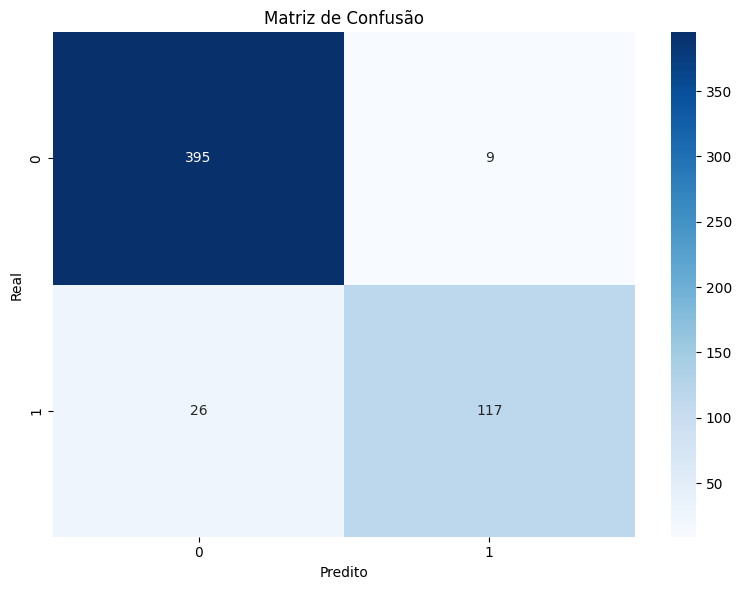

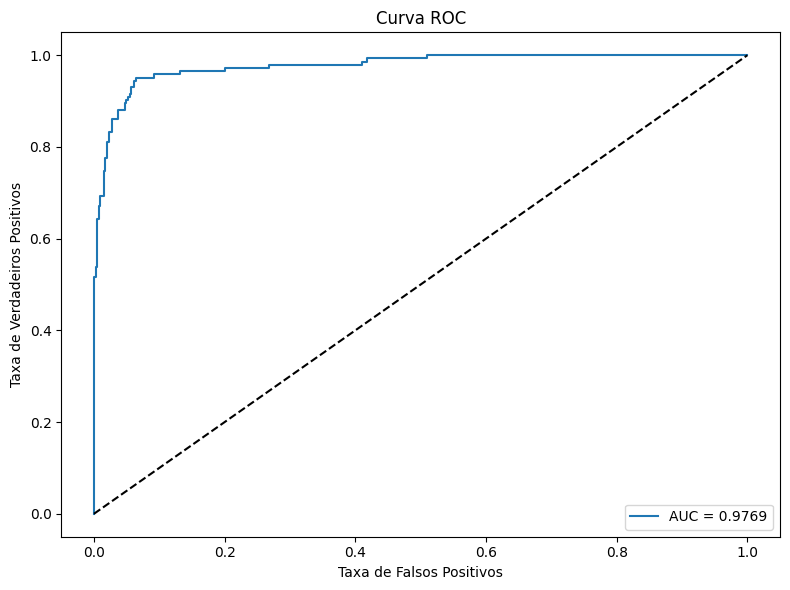

In [6]:
def main():
    # Processa cada dataset individualmente
    for dataset_name, dataset_dir in data_dirs.items():
        print(f"\nProcessando dataset: {dataset_name}")
        model_path = f'best_model_{dataset_name}.keras'
        detector = AudioAnomalyDetector(data_dir=dataset_dir, model_path=model_path)
        df = detector.load_dataset()
        X, y = detector.prepare_data(df)
        history = detector.train(X, y)

if __name__ == "__main__":
    # Para treinar o modelo e realizar predições
    main()

In [7]:
# Exemplo de predição
file_path = '/content/MIMII_dataset/unseen_data/6_dB_fan/fan/id_04/abnormal/00000063.wav'
detector = AudioAnomalyDetector(model_path='best_model_6_dB_fan.keras')
predicted_class = detector.predict_audio(file_path)
print(f'Classe Predita: {predicted_class}')


1/1 [==============================] - 0s 114ms/step


Classe Predita: anomalia
